<h1><strong>DauRuang 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import shutil
from shutil import copyfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

<h2>Load Data

In [3]:
source_path = './data'

#converter to jpg file


list=[]

#Count total images each classes
for i in os.listdir(source_path):
    source_path_item = os.path.join(source_path, i)
    n = 0
    #Converter file to jpg
    for j in os.listdir(source_path_item):
        if j[-3:] == "jpg" or j[-3:] == "gif":
            im = Image.open(os.path.join(source_path_item, j)).convert("RGB")
            im.save(os.path.join(source_path_item, j[:-3]+'jpeg'))
            
            #Removing Original file    
            os.remove(os.path.join(source_path_item, j))
            n += 1

    print("Convert Successful")
    print("Converted image =",n)
    print(f"There are {len(os.listdir(source_path_item))} images of", i + ".\n")
    list.append(i)

Convert Successful
Converted image = 0
There are 100 images of kabel.

Convert Successful
Converted image = 0
There are 100 images of kaca.

Convert Successful
Converted image = 0
There are 100 images of kaleng.

Convert Successful
Converted image = 0
There are 100 images of kertas.

Convert Successful
Converted image = 0
There are 100 images of minyak.

Convert Successful
Converted image = 0
There are 100 images of organik.

Convert Successful
Converted image = 0
There are 100 images of plastik.



<h2>Split Data

In [4]:
root_dir = './temp'

#Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

#Making Split Train and Validation Folder
for i in list:
    os.makedirs(os.path.join(root_dir,"train",i))
    os.makedirs(os.path.join(root_dir,"validation",i))

In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  #Randomize
  random_sample=random.sample(os.listdir(SOURCE_DIR),len(os.listdir(SOURCE_DIR)))
  
  #Split Data Size
  size=int(len(random_sample)*SPLIT_SIZE)

  target=TRAINING_DIR
  i=0

  for item in random_sample:
    
    item_source = os.path.join(SOURCE_DIR, item)

    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    if i == size:
      target = VALIDATION_DIR


In [6]:
train_dir = os.path.join(root_dir,"train")
val_dir = os.path.join(root_dir,"validation")

#Empty directories for run this cell multiple times
for i in os.listdir(train_dir):
  path = os.path.join(train_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

for i in os.listdir(val_dir):
  path = os.path.join(val_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

#Split Size
split_size = .8

#Calling Split Function
for i in list:
  split_data(os.path.join(source_path,i), os.path.join(train_dir, i), os.path.join(val_dir, i), split_size)
  print("Split", i, "Successful")
  print(f"There are {len(os.listdir(os.path.join(train_dir,i)))} images of", i + " for training.")
  print(f"There are {len(os.listdir(os.path.join(val_dir,i)))} images of", i + " for validation.\n")


Split kabel Successful
There are 80 images of kabel for training.
There are 20 images of kabel for validation.

Split kaca Successful
There are 80 images of kaca for training.
There are 20 images of kaca for validation.

Split kaleng Successful
There are 80 images of kaleng for training.
There are 20 images of kaleng for validation.

Split kertas Successful
There are 80 images of kertas for training.
There are 20 images of kertas for validation.

Split minyak Successful
There are 80 images of minyak for training.
There are 20 images of minyak for validation.

Split organik Successful
There are 80 images of organik for training.
There are 20 images of organik for validation.

Split plastik Successful
There are 80 images of plastik for training.
There are 20 images of plastik for validation.



<h2>Making Model

In [7]:
IMG_SHAPE = [224,224]
NUM_CLASSES = 7
BATCH_SIZE = 64 #change for better accuracy based on your dataset
EPOCHS = 100 #change for better accuracy based on your dataset
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [18]:
for layer in base_model.layers:
 layer.trainable = False
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)  
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) 
x = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')(x) 
model = tf.keras.models.Model(inputs = base_model.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [19]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(224,224), shuffle=False, class_mode='categorical')
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(directory=val_dir, target_size=(224,224),shuffle=False, class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [20]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.86):
      print("\nReached 90% validation accuracy so cancelling training!")
      self.model.stop_training = True

In [21]:
callbacks = myCallback()
training_steps_per_epoch = np.ceil(train_generator.samples / BATCH_SIZE)
validation_steps_per_epoch = np.ceil(validation_generator.samples / BATCH_SIZE)
history = model.fit(train_generator, steps_per_epoch = training_steps_per_epoch, 
                    validation_data=validation_generator, validation_steps=validation_steps_per_epoch, 
                    epochs=EPOCHS, verbose=1, callbacks = [callbacks])
print('Training Completed!')

Epoch 1/100
9/9 [==============================] - 62s 7s/step - loss: 2.6483 - accuracy: 0.0368 - val_loss: 2.2383 - val_accuracy: 0.0521
Epoch 2/100
9/9 [==============================] - 84s 10s/step - loss: 1.9857 - accuracy: 0.1354 - val_loss: 1.9503 - val_accuracy: 0.1562
Epoch 3/100
9/9 [==============================] - 79s 9s/step - loss: 1.8706 - accuracy: 0.2757 - val_loss: 1.8952 - val_accuracy: 0.2500
Epoch 4/100
9/9 [==============================] - 81s 9s/step - loss: 1.7441 - accuracy: 0.3299 - val_loss: 1.9376 - val_accuracy: 0.1771
Epoch 5/100
9/9 [==============================] - 77s 9s/step - loss: 1.7102 - accuracy: 0.3162 - val_loss: 1.9609 - val_accuracy: 0.2188
Epoch 6/100
9/9 [==============================] - 80s 9s/step - loss: 1.8836 - accuracy: 0.4306 - val_loss: 2.0026 - val_accuracy: 0.2604
Epoch 7/100
9/9 [==============================] - 81s 9s/step - loss: 1.8547 - accuracy: 0.3264 - val_loss: 1.6808 - val_accuracy: 0.4583
Epoch 8/100
9/9 [=========

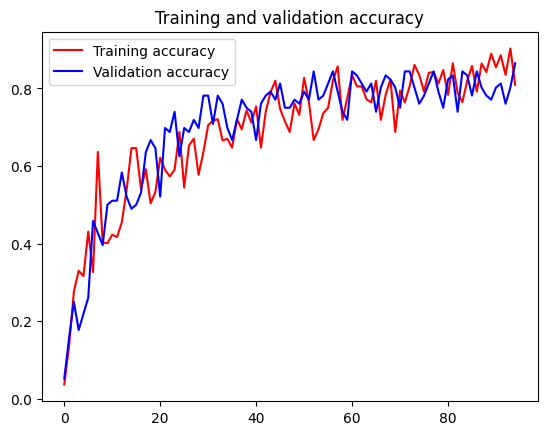

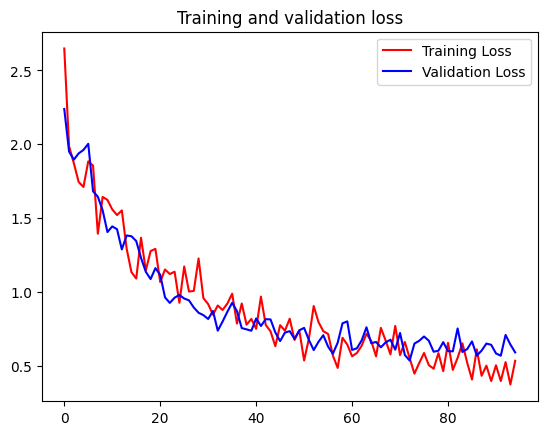

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

C:\Users\acer\AppData\Local\Temp\ipykernel_14704\2404799955.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator)


[[17  0  2  0  0  0  1]
 [ 0 12  2  1  5  0  0]
 [ 0  0 19  0  1  0  0]
 [ 0  0  1 19  0  0  0]
 [ 2  3  0  0 14  0  1]
 [ 0  0  1  0  0 17  2]
 [ 0  4  0  0  0  0 16]]
              precision    recall  f1-score   support

       kabel       0.89      0.85      0.87        20
        kaca       0.63      0.60      0.62        20
      kaleng       0.76      0.95      0.84        20
      kertas       0.95      0.95      0.95        20
      minyak       0.70      0.70      0.70        20
     organik       1.00      0.85      0.92        20
     plastik       0.80      0.80      0.80        20

    accuracy                           0.81       140
   macro avg       0.82      0.81      0.81       140
weighted avg       0.82      0.81      0.81       140



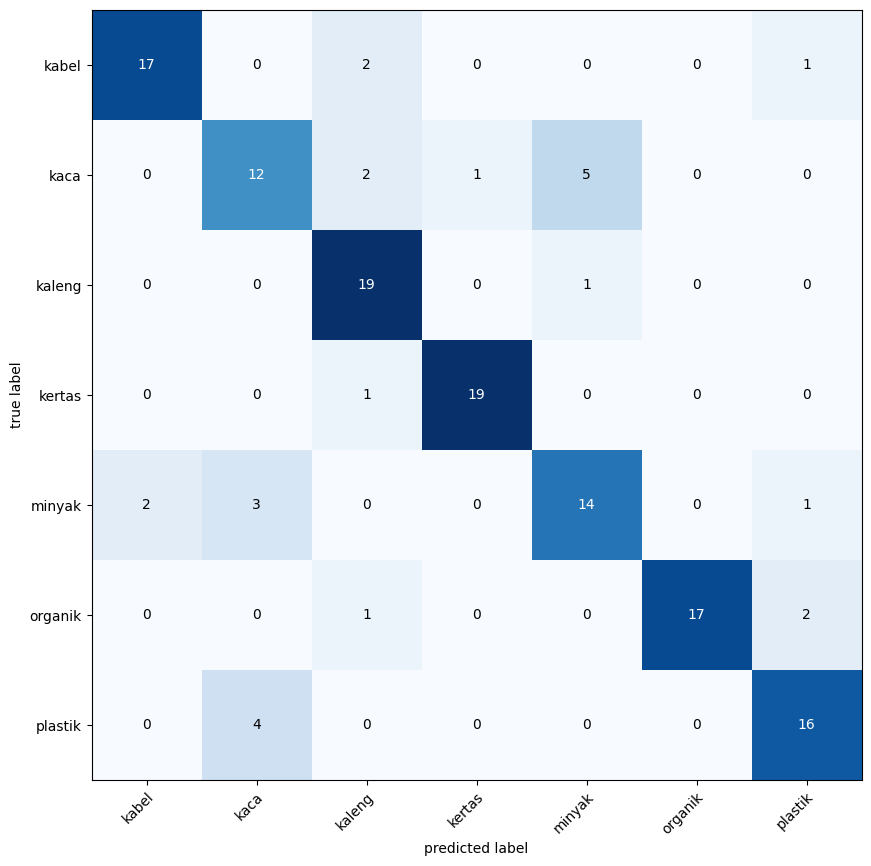

In [23]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
mat = confusion_matrix(validation_generator.classes, y_pred)
print(mat)
plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names= list)
print(classification_report(validation_generator.classes, y_pred, target_names=list))

In [24]:
keras_file = 'Model_v5.h5'
tf.keras.models.save_model(model, keras_file)